In [ ]:
pip install pyswarms

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 5.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Configure GPU memory growth (MUST BE FIRST IN THE SCRIPT)
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    except RuntimeError as e:
        print("Error setting memory growth:", e)
else:
    print("GPU not available. Running on CPU.")

# Import remaining libraries
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, Bidirectional, LSTM, Dense, Attention,
    Dropout, Flatten, LayerNormalization
)
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.utils import class_weight
import pyswarms as ps
import os

# Download GloVe embeddings (run this first in Colab)
if not os.path.exists('glove.6B.zip'):
    print("Downloading GloVe embeddings...")
    !wget -q https://nlp.stanford.edu/data/glove.6B.zip
    !unzip -q glove.6B.zip
    print("Download and extraction complete.")

# Load and preprocess data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Clean data
train_df = train_df.dropna(subset=['Class Index'])
test_df = test_df.dropna(subset=['Class Index'])

X_train, y_train = train_df['Description'].astype(str).fillna(''), train_df['Class Index']
X_test, y_test = test_df['Description'].astype(str).fillna(''), test_df['Class Index']

# Class mapping
unique_classes = sorted(y_train.unique())
class_mapping = {cls: idx for idx, cls in enumerate(unique_classes)}
y_train = y_train.map(class_mapping)
y_test = y_test.map(class_mapping)

# Tokenization and padding
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)

num_classes = len(unique_classes)
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

# Load pre-trained GloVe embeddings
embeddings_index = {}
glove_file = 'glove.6B.100d.txt'  # Adjust path if needed
with open(glove_file, 'r', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_dim = 100
embedding_matrix = np.zeros((10000, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < 10000:
        embedding_vec = embeddings_index.get(word)
        if embedding_vec is not None:
            embedding_matrix[i] = embedding_vec

# PSO objective function with improved setup
def objective_function(params):
    costs = []
    for particle in params:
        lstm_units = int(round(particle[0]))
        dropout_rate = particle[1]
        learning_rate = particle[2]

        # Build model with optimized parameters
        input_layer = Input(shape=(max_length,))
        x = Embedding(
            input_dim=10000,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            input_length=max_length,
            trainable=False
        )(input_layer)

        x = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
        attention_output = Attention()([x, x])
        x = Flatten()(attention_output)
        x = LayerNormalization()(x)  # Add normalization
        x = Dense(128, activation='relu')(x)
        x = Dropout(dropout_rate)(x)
        x = Dense(64, activation='relu')(x)  # Additional layer
        x = Dropout(dropout_rate * 0.8)(x)
        output_layer = Dense(num_classes, activation='softmax')(x)

        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(
            optimizer=tf.keras.optimizers.AdamW(
                learning_rate=learning_rate,
                weight_decay=0.01
            ),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        # Train for quick evaluation
        history = model.fit(
            X_train_pad, y_train_cat,
            epochs=2,
            batch_size=32,
            validation_split=0.2,
            verbose=0
        )
        val_acc = history.history['val_accuracy'][-1]
        costs.append(-val_acc)

    return np.array(costs)

# PSO parameters (optimized for speed)
lb = np.array([32, 0.2, 0.0001])  # [lstm_units, dropout, lr]
ub = np.array([128, 0.5, 0.01])

options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
optimizer = ps.single.GlobalBestPSO(
    n_particles=5,
    dimensions=3,
    options=options,
    bounds=(lb, ub)
)

print("Starting PSO optimization...")
cost, pos = optimizer.optimize(objective_function, iters=5)
print("Optimization complete!")

best_params = {
    'lstm_units': int(round(pos[0])),
    'dropout_rate': pos[1],
    'learning_rate': pos[2]
}

# Build final model with optimized parameters and advanced features
input_layer = Input(shape=(max_length,))
x = Embedding(
    input_dim=10000,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=max_length,
    trainable=False
)(input_layer)

x = Bidirectional(LSTM(best_params['lstm_units'], return_sequences=True))(x)
attention_output = Attention()([x, x])
x = Flatten()(attention_output)
x = LayerNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(best_params['dropout_rate'])(x)
x = Dense(64, activation='relu')(x)
x = Dropout(best_params['dropout_rate'] * 0.8)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)

# Advanced training setup
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Compute class weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

model.compile(
    optimizer=tf.keras.optimizers.AdamW(
        learning_rate=best_params['learning_rate'],
        weight_decay=0.01
    ),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train with class weights and early stopping
history = model.fit(
    X_train_pad, y_train_cat,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[es]
)

# Evaluate
y_pred = model.predict(X_test_pad).argmax(axis=1)
y_test = np.argmax(y_test_cat, axis=1)

print("\nFinal Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted'):.4f}")

# Confusion Matrix (optional)
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.show()

Download and extraction complete.


2025-03-16 17:25:15,858 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Starting PSO optimization...


pyswarms.single.global_best:   0%|          |0/5/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
pyswarms.single.global_best: 100%|██████████|5/5, best_cost=-0.896
2025-03-16 18:25:02,938 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.8963150382041931, best pos: [9.78822948e+01 2.72843282e-01 1.88595974e-03]


Optimization complete!
Epoch 1/20
2969/2969 ━━━━━━━━━━━━━━━━━━━━ 58s 18ms/step - accuracy: 0.7570 - loss: 0.8555 - val_accuracy: 0.8890 - val_loss: 0.3867
Epoch 2/20
2969/2969 ━━━━━━━━━━━━━━━━━━━━ 81s 18ms/step - accuracy: 0.8747 - loss: 0.3933 - val_accuracy: 0.8860 - val_loss: 0.3374
Epoch 3/20
2969/2969 ━━━━━━━━━━━━━━━━━━━━ 81s 18ms/step - accuracy: 0.8936 - loss: 0.3394 - val_accuracy: 0.8993 - val_loss: 0.3156
Epoch 4/20
2969/2969 ━━━━━━━━━━━━━━━━━━━━ 82s 18ms/step - accuracy: 0.9022 - loss: 0.3092 - val_accuracy: 0.8997 - val_loss: 0.3003
Epoch 5/20
2969/2969 ━━━━━━━━━━━━━━━━━━━━ 53s 18ms/step - accuracy: 0.9077 - loss: 0.2889 - val_accuracy: 0.9000 - val_loss: 0.3094
Epoch 6/20
2969/2969 ━━━━━━━━━━━━━━━━━━━━ 81s 18ms/step - accuracy: 0.9139 - loss: 0.2680 - val_accuracy: 0.9040 - val_loss: 0.2824
Epoch 7/20
2969/2969 ━━━━━━━━━━━━━━━━━━━━ 88s 20ms/step - accuracy: 0.9198 - loss: 0.2492 - val_accuracy: 0.8877 - val_loss: 0.2960
Epoch 8/20
2969/2969 ━━━━━━━━━━━━━━━━━━━━ 78s 18ms/st

NameError: name 'sns' is not defined

<Figure size 1000x800 with 0 Axes>

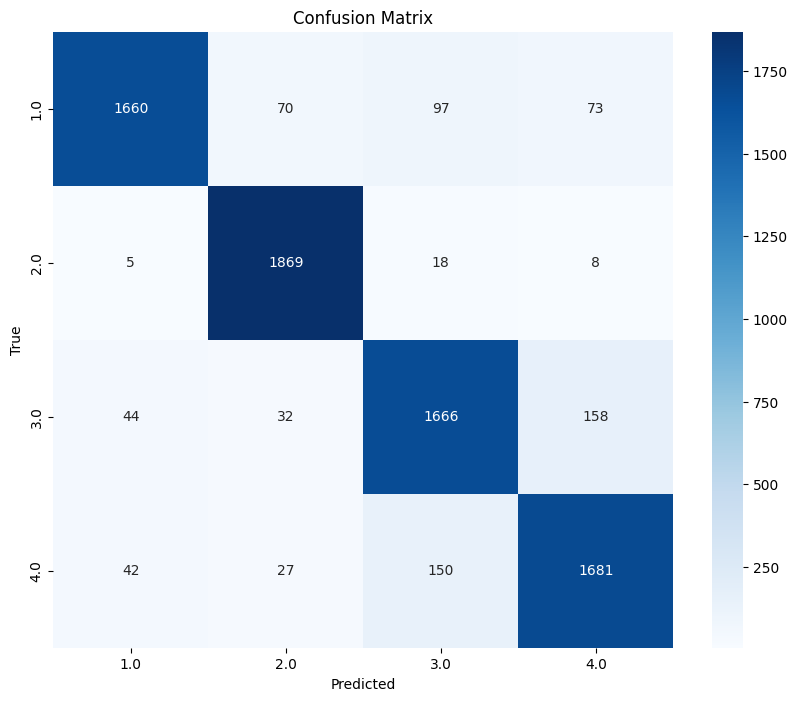

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_classes, yticklabels=unique_classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


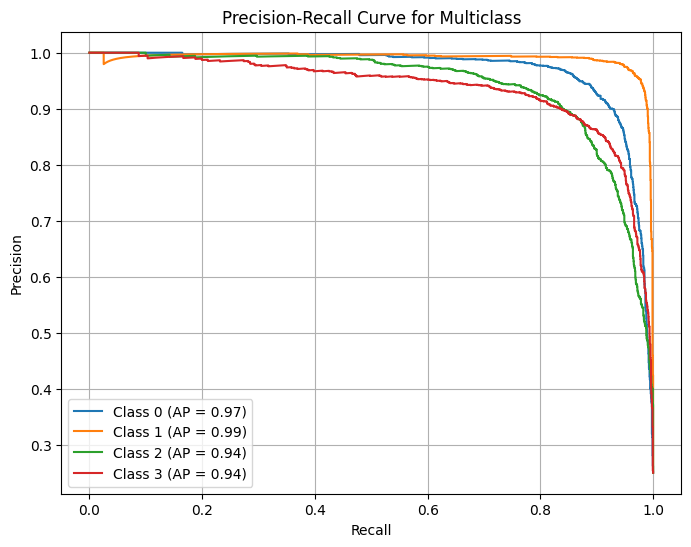

Average Precision for Class 0: 0.9693
Average Precision for Class 1: 0.9905
Average Precision for Class 2: 0.9420
Average Precision for Class 3: 0.9366


In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the labels for multiclass Precision-Recall curve
y_test_bin = label_binarize(y_test, classes=np.arange(num_classes))

# Get predicted probabilities for each class (softmax output)
y_pred_prob = model.predict(X_test_pad)

# Initialize variables to store precision-recall curves and AUC for each class
precision = {}
recall = {}
avg_precision = {}

# Calculate precision-recall curve for each class
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_pred_prob[:, i])
    avg_precision[i] = average_precision_score(y_test_bin[:, i], y_pred_prob[:, i])

# Plot precision-recall curve for each class
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(recall[i], precision[i], label=f'Class {i} (AP = {avg_precision[i]:.2f})')

plt.title('Precision-Recall Curve for Multiclass')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

# Print average precision for each class
for i in range(num_classes):
    print(f'Average Precision for Class {i}: {avg_precision[i]:.4f}')


238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


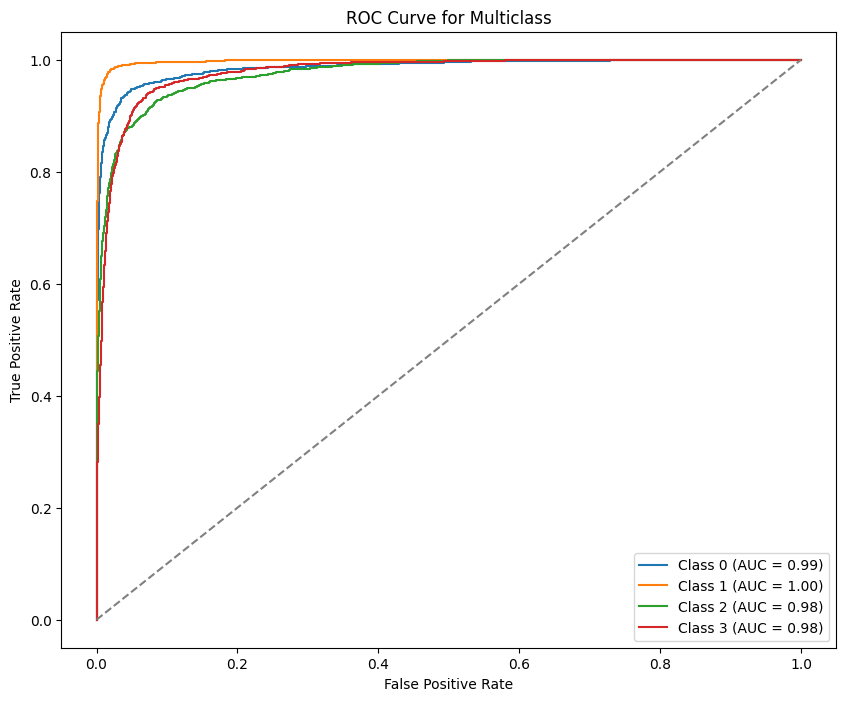

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the labels for multiclass ROC curve
y_test_bin = label_binarize(y_test, classes=np.arange(num_classes))

# Get predicted probabilities for each class (softmax output)
y_pred_prob = model.predict(X_test_pad)

# Calculate ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve for Multiclass')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


In [ ]:
model.save("text_classification_model.h5")

2025-03-11 20:14:20,146 - absl - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


In [ ]:
!pip install joblib

In [ ]:
# Save the tokenizer after fitting it on the training data
import joblib
joblib.dump(tokenizer, "tokenizer.joblib")

['tokenizer.joblib']